# Introduction

As is known to all, body fat percentage is an important measure of obesity and plays an important role in various health outcomes. However, usually it is difficult and complicated to calculate since the information needed like underwater weighing is not applicable in practice. In this project, we are aiming to derive an accurate and precise "rule-of-thumb" method to estimate percentage of body fat with few clinically available measurements. From the provided dataset, which is consisting of bodyfat calculated by siri equation and many body measures among 252 males, we found that weight and abdomen are strongly correlated with bodyfat. We built, diagnosed and tested the model in the statistical analysis below. The model established achieves high performance over the provided dataset.

# Statistical Analysis

## 1. Load Data and Packages

In [1]:
## assume working directory is the one that current juno is in
remove(list = ls())
set.seed(1)
dt.path = "Data/BodyFat.csv"
dt.fat = read.csv(dt.path)
body.fat = subset(dt.fat, select = c(-IDNO, -DENSITY))

In [2]:
suppressMessages(if(!require("dplyr")){install.packages("dplyr")})
suppressMessages(if(!require("tidyverse")){install.packages("tidyverse")})
suppressMessages(if(!require("caret")){install.packages("caret")})

## 2. Data Description

The dataset consists of bady fat calculated from siri's equation, density from underwater weighing, age, weight, height, BMI, neck circumference, chest circumference, abcomen circumference, hip circumference, thigh circumference, knee circumference, ankle circumference, biceps circumference, forearm circumference and wrist circumference. To have an intuitive view of the data set, we first draw histgrams for some features.

In [3]:
#summary(dt.fat[,-1])

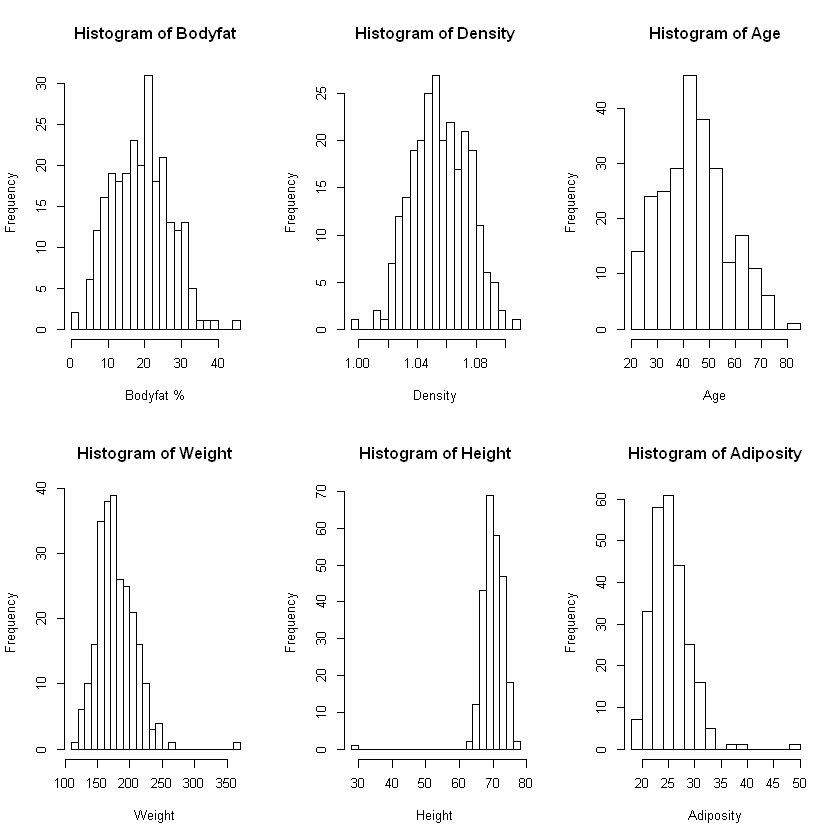

In [4]:
par(mfrow=c(2,3))
hist(dt.fat$BODYFAT,breaks = 20, 
     main = "Histogram of Bodyfat",xlab="Bodyfat %")
hist(dt.fat$DENSITY,breaks = 20, 
     main = "Histogram of Density",xlab="Density")
hist(dt.fat$AGE,breaks = 20, 
     main = "Histogram of Age",xlab="Age")
hist(dt.fat$WEIGHT,breaks = 20, 
     main = "Histogram of Weight",xlab="Weight")
hist(dt.fat$HEIGHT,breaks = 20, 
     main = "Histogram of Height",xlab="Height")
hist(dt.fat$ADIPOSITY,breaks = 20, 
     main = "Histogram of Adiposity",xlab="Adiposity")

We note that there might be some outliers for each feature so we deal with the data cleaning in the next part.

In [5]:
# More description?

## 3. Data Cleaning

Given Siri's equation, we know that
$$B = \frac{495}{D} - 450\ ,\ where$$
* B = proportion of fat tissue * 100 = BODYFAT
* D = Body Density = DENSITY

We plot body fat against $\frac{1}{Density}$ and there are some points lie out of the line. The individuals whose bodyfats are not equal to the bodyfat computed by density may be wrong records. Thus we compute the bodyfat using siri's equation and density to locate those outliers and look into them for imputation or deletion.

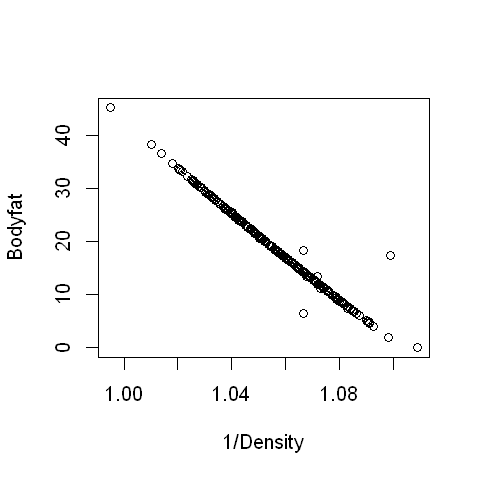

In [6]:
options(repr.plot.width=4, repr.plot.height=4)
plot(dt.fat$BODYFAT ~ 1/dt.fat$DENSITY,xlab = "1/Density",ylab = "Bodyfat")
id<-as.vector(dt.fat$IDNO)
bodyf<-as.vector(dt.fat$BODYFAT)
den<-as.vector(dt.fat$DENSITY)
diff<-abs(bodyf -(495/den-450))
ab<-cbind(id,diff)
#ab[order(ab[,2],decreasing = T),][1:10,]

In [7]:
col.mean1 = round(sapply(cbind(495/den-450,dt.fat[,-1]), dim = 1, FUN = mean), digits = 2)
bd = rbind(cbind(495/den[c(182,96, 48,54, 76,124)]-450,dt.fat[c(182,96, 48,54, 76,124), -1]), col.mean1)
colnames(bd)[1] = "BODYFAT_computed"
rownames(bd)[4] = '54 (compared with 48)'
rownames(bd)[6] = '124 (compared with 76)'
rownames(bd)[7] = ' Sample Mean'
bd

,BODYFAT_computed,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
182,-3.6116873,0.00,1.1089,40.00,118.50,68.00,18.10,33.80,79.30,69.40,85.0,47.20,33.50,20.2,27.70,24.60,16.50
96,0.3684833,17.30,1.0991,53.00,224.50,77.75,26.10,41.10,113.20,99.20,107.5,61.70,42.30,23.2,32.90,30.80,20.40
48,14.1350211,6.40,1.0665,39.00,148.50,71.25,20.60,34.60,89.80,79.50,92.7,52.70,37.50,21.9,28.80,26.80,17.90
54 (compared with 48),6.3053097,7.10,1.0848,49.00,152.75,73.50,19.90,35.10,93.30,79.60,91.6,52.60,37.60,22.6,38.50,27.40,18.50
76,14.0915057,18.30,1.0666,61.00,148.25,67.50,22.90,36.00,91.60,81.80,94.8,54.50,37.00,21.4,29.30,27.00,18.30
124 (compared with 76),15.9700650,16.00,1.0623,47.00,151.50,66.75,23.90,36.90,94.00,86.10,95.2,58.10,36.50,22.1,30.60,27.50,17.60
Sample Mean,19.0900000,18.94,1.0600,44.88,178.92,70.15,25.44,37.99,100.82,92.56,99.9,59.41,38.59,23.1,32.27,28.66,18.23


**For No.182:**
No one's bodyfat can be 0 or negative. Therefore we should delete this abnormal point(No.182).

**For No.96:**
The bodyfat computed by the density is 495/1.0991-450=0.3684833. It is very close to 0. Therefore we think the density is wrong meanwhile the bodyfat is right. So we will keep this point.

**For No.48:**
We find a normal point(No.54) which is very similar with No.48 point except AGE and BICEPS. But these two factors influence bodyfat little. Therefore we think the bodyfat of No.48 point is normal. Then we keep this point.

**For No.76:**
We find a normal point(No.124) which is very similar with No.76 point .Therefore we think the bodyfat of No.76 point is normal. Then we keep this point.

From the histgram of height in the previous part, we notice that there is a person whose height is around 30 inches. But when we look into this point, we find that his weight and BMI are quite normal, so we take the height as a wrong record and use $ADIPOSITY = \frac{WEIGHT}{HIGHT^2} $ to impute it.
Using this formula, we also find No.163 and No.221 as two possible bad points candidates.
Similarly, we also look into the outliers in other features.

In [8]:
# Impute the height for the shortest man
body.fat$HEIGHT[42] = round(sqrt(205*0.45359237/29.9)*39.3700787,1)
# The person with largest bodyfat
dt.fat[dt.fat$BODYFAT==max(dt.fat$BODYFAT), ]
body.fat.clean <- body.fat[-c(182,216),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
216,216,45.1,0.995,51,219,64,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


The one with bodyfat 45.1% is too impossible  to exist in the world and his density is smaller than 1. So we delete this example.

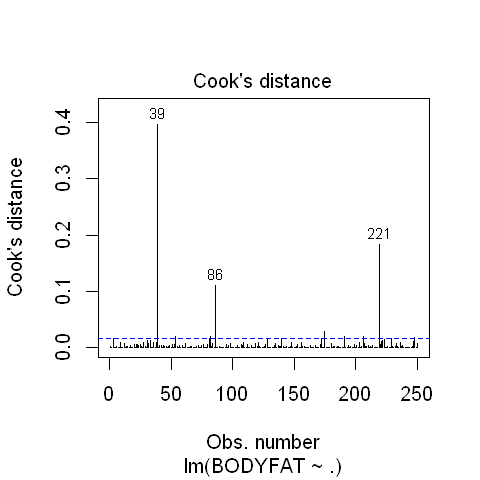

In [9]:
model.clean = lm(BODYFAT ~ ., data = body.fat.clean)
# summary(model.clean)$coefficient
plot(model.clean, which = 4)
abline(h = 4/(dim(body.fat)[1]-dim(body.fat)[2]), lty = 2, col = 'blue')

In [10]:
col.mean = round(sapply(body.fat, dim = 1, FUN = mean), digits = 2)
. = rbind(body.fat[c(39, 86, 221), ], col.mean)
rownames(.)[4] = ' Sample Mean'
.

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.80,46.00,363.15,72.25,48.90,51.20,136.20,148.10,147.7,87.30,49.10,29.6,45.00,29.00,21.40
86,25.80,67.00,167.00,67.50,26.00,36.50,98.90,89.70,96.2,54.70,37.80,33.7,32.40,27.70,18.20
221,12.70,54.00,153.25,70.50,24.50,38.50,99.00,91.80,96.2,57.70,38.10,23.9,31.40,29.90,18.90
Sample Mean,18.94,44.88,178.92,70.31,25.44,37.99,100.82,92.56,99.9,59.41,38.59,23.1,32.27,28.66,18.23


* Sample 39 is highly overweighted.However, \#39 is merely a stronger person whose body measurements are within normal range. 
* Sample 86 has relatively larger Cook's distance. However, \#86 is merely a person whose body measurements are within normal range. 
* Sample 221 has normal body measurements and he is a really fit person.

Therefore, \#39, \#86 and \#221 should be kept in our model.

**Given the above, $163, 182, 216$ show up as outlier candidates.**

In [11]:
body.fat.clean = body.fat[-c(163, 182,216),]

In [12]:
# options(repr.plot.width=5, repr.plot.height=5)
# model.clean2 = lm(BODYFAT ~ ., data = body.fat.clean)
# layout(matrix(1:4, ncol = 2))
# plot(model.clean2)
# Do we need?

## 3. Variable Selection

### Linear Model

#### Forward selection using AIC

In [13]:
model.clean2 = lm(BODYFAT ~ ., data = body.fat.clean)
model.1 <- lm(BODYFAT~1,data = body.fat.clean)
model.AIC.forward <- step(model.1,list(lower = model.1,upper = model.clean2),k = 2,direction = "forward",trace = 0)
summary(model.AIC.forward)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + 
    BICEPS + AGE + THIGH + HIP, data = body.fat.clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1521  -2.6483  -0.0242   2.7992   9.4679 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -19.74731   11.06768  -1.784  0.07565 .  
ABDOMEN       0.85672    0.06794  12.610  < 2e-16 ***
WEIGHT       -0.08717    0.03826  -2.279  0.02358 *  
WRIST        -1.36738    0.47545  -2.876  0.00439 ** 
FOREARM       0.41728    0.18125   2.302  0.02218 *  
NECK         -0.45634    0.20978  -2.175  0.03059 *  
BICEPS        0.15282    0.15571   0.981  0.32738    
AGE           0.06043    0.02879   2.099  0.03688 *  
THIGH         0.27626    0.12552   2.201  0.02870 *  
HIP          -0.18777    0.12908  -1.455  0.14706    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.951 on 239 degrees of freedom
Multiple R-squared:  0.7336,	Adj

#### Backward selection using AIC

In [14]:
model.AIC.backward <- step(model.clean2,k = 2,direction = "backward",trace = 0)
summary(model.AIC.backward)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + HIP + 
    THIGH + FOREARM + WRIST, data = body.fat.clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1325  -2.7879  -0.1165   2.7325   9.6502 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -19.28149   11.05665  -1.744  0.08246 .  
AGE           0.06247    0.02871   2.176  0.03056 *  
WEIGHT       -0.07997    0.03755  -2.130  0.03419 *  
NECK         -0.43369    0.20849  -2.080  0.03857 *  
ABDOMEN       0.85266    0.06781  12.574  < 2e-16 ***
HIP          -0.19866    0.12859  -1.545  0.12368    
THIGH         0.30912    0.12096   2.556  0.01122 *  
FOREARM       0.47278    0.17219   2.746  0.00650 ** 
WRIST        -1.35941    0.47535  -2.860  0.00461 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.951 on 240 degrees of freedom
Multiple R-squared:  0.7325,	Adjusted R-squared:  0.7236 
F-statistic: 82.15 on 8 and 240 DF,  

#### Forward selection using BIC

In [15]:
model.BIC.forward <- step(model.1,list(lower = model.1,upper = model.clean2),k = log(dim(body.fat.clean)[1]),direction = "forward",trace = 0)
summary(model.BIC.forward)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, data = body.fat.clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8084 -2.8926 -0.0708  2.8601  8.3356 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -30.86008    6.77840  -4.553 8.36e-06 ***
ABDOMEN       0.90524    0.05301  17.078  < 2e-16 ***
WEIGHT       -0.12356    0.02301  -5.371 1.83e-07 ***
WRIST        -1.33925    0.41283  -3.244  0.00134 ** 
FOREARM       0.43804    0.16831   2.603  0.00982 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.013 on 244 degrees of freedom
Multiple R-squared:  0.7193,	Adjusted R-squared:  0.7147 
F-statistic: 156.3 on 4 and 244 DF,  p-value: < 2.2e-16


#### Backward selection using BIC

In [16]:
model.BIC.backward <- step(model.clean2,k = log(dim(body.fat.clean)[1]),direction = "backward",trace = 0)
summary(model.BIC.backward)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST, data = body.fat.clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8084 -2.8926 -0.0708  2.8601  8.3356 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -30.86008    6.77840  -4.553 8.36e-06 ***
WEIGHT       -0.12356    0.02301  -5.371 1.83e-07 ***
ABDOMEN       0.90524    0.05301  17.078  < 2e-16 ***
FOREARM       0.43804    0.16831   2.603  0.00982 ** 
WRIST        -1.33925    0.41283  -3.244  0.00134 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.013 on 244 degrees of freedom
Multiple R-squared:  0.7193,	Adjusted R-squared:  0.7147 
F-statistic: 156.3 on 4 and 244 DF,  p-value: < 2.2e-16


#### Back/forward selection uing A/BIC

In [17]:
model.full = lm(BODYFAT ~ ., body.fat.clean)

In [18]:
model.aic.both = step(model.full, direction = "both", k = 2, trace = 0)
summary(model.aic.both)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + HIP + 
    THIGH + FOREARM + WRIST, data = body.fat.clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1325  -2.7879  -0.1165   2.7325   9.6502 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -19.28149   11.05665  -1.744  0.08246 .  
AGE           0.06247    0.02871   2.176  0.03056 *  
WEIGHT       -0.07997    0.03755  -2.130  0.03419 *  
NECK         -0.43369    0.20849  -2.080  0.03857 *  
ABDOMEN       0.85266    0.06781  12.574  < 2e-16 ***
HIP          -0.19866    0.12859  -1.545  0.12368    
THIGH         0.30912    0.12096   2.556  0.01122 *  
FOREARM       0.47278    0.17219   2.746  0.00650 ** 
WRIST        -1.35941    0.47535  -2.860  0.00461 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.951 on 240 degrees of freedom
Multiple R-squared:  0.7325,	Adjusted R-squared:  0.7236 
F-statistic: 82.15 on 8 and 240 DF,  

In [19]:
model.bic.both = step(model.full, direction = "both", k = log(dim(body.fat.clean)[1]), trace = 0)
summary(model.bic.both)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST, data = body.fat.clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8084 -2.8926 -0.0708  2.8601  8.3356 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -30.86008    6.77840  -4.553 8.36e-06 ***
WEIGHT       -0.12356    0.02301  -5.371 1.83e-07 ***
ABDOMEN       0.90524    0.05301  17.078  < 2e-16 ***
FOREARM       0.43804    0.16831   2.603  0.00982 ** 
WRIST        -1.33925    0.41283  -3.244  0.00134 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.013 on 244 degrees of freedom
Multiple R-squared:  0.7193,	Adjusted R-squared:  0.7147 
F-statistic: 156.3 on 4 and 244 DF,  p-value: < 2.2e-16


#### Mallow's Cp

In [20]:
#detach("package:car")
install.packages("leaps")
library("leaps") # for leaps()
install.packages("faraway")
library("faraway") # for Cpplot()

package 'leaps' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\shuya\AppData\Local\Temp\RtmpacWJ6f\downloaded_packages
package 'faraway' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\shuya\AppData\Local\Temp\RtmpacWJ6f\downloaded_packages



Attaching package: 'faraway'

The following object is masked from 'package:lattice':

    melanoma



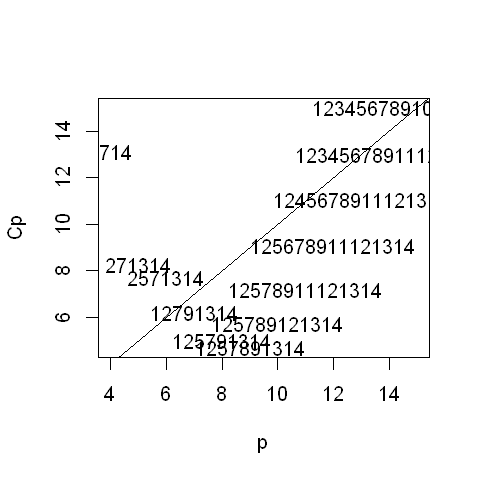

In [21]:
X = model.matrix(model.full)[,-1]
Y = body.fat.clean[,1]
g = leaps::leaps(X,Y,nbest=1)
Cpplot(g) # Include all variable.

#### $R^2$

1     2     3     4     5     6     7     8     9     A     B     C     D 
 TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE 
    E 
 TRUE

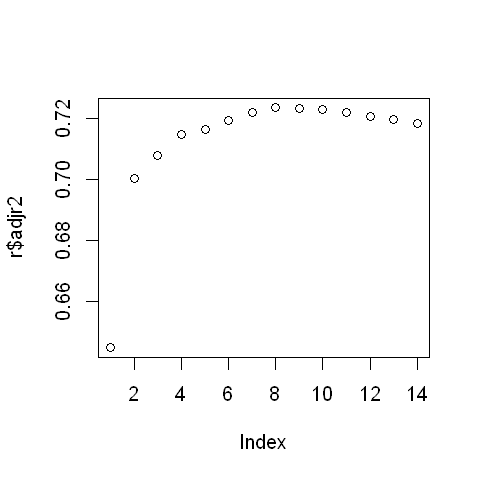

In [22]:
r = leaps::leaps(X,Y,nbest=1, method="adjr2")
plot(r$adjr2)
(r$which)[which(r$adjr2 == max(r$adjr2)),] # 1,2,3,7,12,13

### Fraction Model

$$\text{Bodyfat }= \beta_1 \frac{X_1}{\text{Weight}} + \beta_2 \frac{1}{\text{Weight}} + \beta_3$$

where $X_1$ is chosen from the remaining variables. 

In [23]:
data = body.fat.clean
data.invwei <- data.frame(BODYFAT = data$BODYFAT,HEIGHT = data$HEIGHT/data$WEIGHT,
                          ADIPOSITY = data$ADIPOSITY/data$WEIGHT,NECK = data$NECK/data$WEIGHT,
                          CHEST = data$CHEST/data$WEIGHT,ABDOMEN = data$ABDOMEN/data$WEIGHT,
                          HIP = data$HIP/data$WEIGHT,THIGH = data$THIGH/data$WEIGHT,
                          KNEE = data$KNEE/data$WEIGHT,ANKLE = data$ANKLE/data$WEIGHT,
                          BICEPS = data$BICEPS/data$WEIGHT,FOREARM = data$FOREARM/data$WEIGHT,
                          WRIST = data$WRIST/data$WEIGHT)
data.invwei$inv_wei <- 1/data$WEIGHT

In [24]:
BF.nonlinear = body.fat.clean
kFoldCV = 10

nonWeightCol = c(2, seq(4, 15))
WeightCol = c(3)

BF.nonlinear[, nonWeightCol] = BF.nonlinear[, nonWeightCol] / BF.nonlinear[, WeightCol]
BF.nonlinear$invWeight = 1 / BF.nonlinear$WEIGHT
BF.nonlinear$WEIGHT = NULL

fracModelsInfo = data.frame(matrix(ncol = 3, nrow = length(nonWeightCol)))
colnames(fracModelsInfo) = c("Variable.Name", "RMSE", "rSquare")

set.seed(123) 
train.control = trainControl(method = "cv", number = kFoldCV)

for(i in seq(2, 14)){
    varName = colnames(BF.nonlinear)[i]
    model = train(BODYFAT ~ . , data = BF.nonlinear[, c("BODYFAT", "invWeight", varName)],
                  method = "lm", trControl = train.control)
    
    fracModelsInfo$Variable.Name[i-1] = varName
    fracModelsInfo$RMSE[i-1] = model$results[, 'RMSE']
    fracModelsInfo$rSquare[i-1] = model$results[, 'Rsquared']
    # fracModelsInfo$model[i-1] = model$finalModel
}

In [25]:
cat("Best Model by RMSE")
fracModelsInfo[ which.min(fracModelsInfo$RMSE),  ]
cat("Best Model by R Square")
fracModelsInfo[ which.max(fracModelsInfo$rSquare),  ]

fracModelBestVar = fracModelsInfo[ which.min(fracModelsInfo$RMSE), 'Variable.Name']

cat("Sorted by RMSE")
fracModelsInfo[ order(fracModelsInfo$RMSE), ]
cat("Sorted by R Square")
fracModelsInfo[ order(fracModelsInfo$rSquare, decreasing = TRUE), ]

Best Model by RMSE

,Variable.Name,RMSE,rSquare
6,ABDOMEN,4.106067,0.7097229


Best Model by R Square

,Variable.Name,RMSE,rSquare
6,ABDOMEN,4.106067,0.7097229


Sorted by RMSE

,Variable.Name,RMSE,rSquare
6,ABDOMEN,4.106067,0.7097229
3,ADIPOSITY,5.069200,0.5585059
2,HEIGHT,5.091234,0.5570014
5,CHEST,5.421535,0.4889839
1,AGE,5.445023,0.4781106
13,WRIST,5.763896,0.4182184
7,HIP,5.766817,0.4217126
8,THIGH,5.845911,0.4030650
10,ANKLE,5.857416,0.3960387
12,FOREARM,5.864272,0.4028571


Sorted by R Square

,Variable.Name,RMSE,rSquare
6,ABDOMEN,4.106067,0.7097229
3,ADIPOSITY,5.069200,0.5585059
2,HEIGHT,5.091234,0.5570014
5,CHEST,5.421535,0.4889839
1,AGE,5.445023,0.4781106
7,HIP,5.766817,0.4217126
13,WRIST,5.763896,0.4182184
8,THIGH,5.845911,0.4030650
12,FOREARM,5.864272,0.4028571
9,KNEE,5.876304,0.4017343


In [26]:
frac.model.1 = lm(BODYFAT ~ . , data = BF.nonlinear[, c("BODYFAT", "invWeight", fracModelBestVar)])
summary(frac.model.1) # >>> the intercept is not significant so we consider drop it in the next model. 

frac.model.2 = lm(BODYFAT ~ . -1, data = BF.nonlinear[, c("BODYFAT", "invWeight", fracModelBestVar)])
summary(frac.model.2)


Call:
lm(formula = BODYFAT ~ ., data = BF.nonlinear[, c("BODYFAT", 
    "invWeight", fracModelBestVar)])

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6759  -2.9917  -0.0988   2.8047   9.1034 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.428      3.566  -0.401    0.689    
invWeight   -10684.826    442.715 -24.135   <2e-16 ***
ABDOMEN        156.262      9.594  16.288   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.097 on 246 degrees of freedom
Multiple R-squared:  0.7052,	Adjusted R-squared:  0.7028 
F-statistic: 294.2 on 2 and 246 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ . - 1, data = BF.nonlinear[, c("BODYFAT", 
    "invWeight", fracModelBestVar)])

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6455  -3.0098  -0.0213   2.6851   9.2262 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
invWeight -10626.109    417.034  -25.48   <2e-16 ***
ABDOMEN      152.894      4.615   33.13   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.09 on 247 degrees of freedom
Multiple R-squared:   0.96,	Adjusted R-squared:  0.9597 
F-statistic:  2963 on 2 and 247 DF,  p-value: < 2.2e-16


## 4. Multicolinearity in the linear model

From the above study, we can get two simple models. If we consider the simple liear model, we get a model with four variables in the end: 

\begin{equation}
\text{BODYFAT} = \text{WEIGHT} + \text{ABDOMEN} + \text{FOREARM} + \text{WRIST}
\end{equation}

Next, we are going to detect multicolinearity problem among the four variables.

In [27]:
#install.packages("caret")
#install.packages("car")
library(caret)
library(car)
attach(body.fat.clean)

Loading required package: carData
Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

Attaching package: 'car'

The following objects are masked from 'package:faraway':

    logit, vif

The following object is masked from 'package:purrr':

    some

The following object is masked from 'package:dplyr':

    recode



In [28]:
training.index = sample(1:dim(body.fat.clean)[1],size = 0.7*dim(body.fat.clean)[1])
training.set = body.fat.clean[training.index,]
test.set = body.fat.clean[-training.index,]

In [29]:
# Full model with four variables
m1 = lm(BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST, data = training.set)
predictions = predict(m1,test.set)
df1 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))
vif(m1)

WEIGHT  ABDOMEN  FOREARM    WRIST 
7.667854 5.160732 1.893408 2.318295

From the full model, **weight** has the highest VIF value and it may have some multicolinearity problem. In order to find two variables that has the best prediction power while suffer less from multicoliearity problem, we are going to drop the variables gradually to see whether the model performance changes a lot.

In [30]:
# Drop WEIGHT >>> model performance does not change too much so we can dropping weight might be helpful with multicolinearity
m2 = lm(BODYFAT ~ ABDOMEN + FOREARM + WRIST, data = training.set)
predictions = predict(m2,test.set)
df2 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WEIGHT + ABDOMEN >>> model performance gets worse so we can not drop ABDOMEN
m3 = lm(BODYFAT ~ FOREARM + WRIST, data = training.set)
predictions = predict(m3,test.set)
df3 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WEIGHT + FOREARM
m4 = lm(BODYFAT ~ ABDOMEN + WRIST, data = training.set)
predictions = predict(m4,test.set)
df4 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WEIGHT + WRIST
m5 = lm(BODYFAT ~ ABDOMEN + FOREARM, data = training.set)
predictions = predict(m5,test.set)
df5 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WRIST + FOREARM
m6 = lm(BODYFAT ~ WEIGHT + ABDOMEN, data = training.set)
predictions = predict(m6,test.set)
df6 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

In [31]:
result= data.frame(c("Full model", "ABDOMEN + FOREARM + WRIST", "FOREARM + WRIST",
                            "ABDOMEN + WRIST", "ABDOMEN + FOREARM","WEIGHT + ABDOMEN"))
df = rbind(df1, df2, df3, df4, df5, df6)
result = cbind(result, df)
colnames(result) = c("Models", "RMSE", "R2")
result

Models,RMSE,R2
Full model,4.184500,0.6763756
ABDOMEN + FOREARM + WRIST,3.961650,0.7038511
FOREARM + WRIST,6.816261,0.1174587
ABDOMEN + WRIST,3.877866,0.7181278
ABDOMEN + FOREARM,4.147919,0.6755324
WEIGHT + ABDOMEN,3.977992,0.7025314


From the above table, we can conclude than 
\begin{equation}
BODYFAT = ABDOMEN + WRIST
\end{equation}
is the best linear models.

In [32]:
linear.model = lm(BODYFAT~ABDOMEN+WRIST,data = body.fat.clean)
summary(linear.model)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST, data = body.fat.clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.5970  -3.0393  -0.0836   3.0330  10.6110 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.96883    5.42479  -1.285      0.2    
ABDOMEN      0.68294    0.03253  20.995  < 2e-16 ***
WRIST       -2.04567    0.37095  -5.515 8.83e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.233 on 246 degrees of freedom
Multiple R-squared:  0.6853,	Adjusted R-squared:  0.6827 
F-statistic: 267.8 on 2 and 246 DF,  p-value: < 2.2e-16


## 4. Compare the linear model and fraction model

Now we have two models. The linear model:
\begin{equation}
\text{Bodyfat} = 0.683 \times \text{Abdomen} -2.046 \times \text{Wrist}, R^2 = 0.6827
\end{equation}
The fraction model:
\begin{equation}
\text{Bodyfat }= 152.894 \times \frac{\text{Abdomen}}{\text{Weight}} - 10626.109 \times \frac{1}{\text{Weight}}, R^2 = 0.9597
\end{equation}

# Contributions of each member